In [1]:
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


INSPIRATION FROM THE FOLLOWING BLOG 

https://medium.com/aimonks/traveling-salesman-problem-tsp-using-genetic-algorithm-fea640713758

https://stackoverflow.com/questions/50489450/genetic-algorithm-ordered-crossover-in-python

https://mat.uab.cat/~alseda/MasterOpt/GeneticOperations.pdf

We tried implementing some sort of ordered crossover, the results are not great... 

-> of course, ChatGPT did come in handy for when we had small mistakes in the code

In [2]:
from random import randrange, random
from random import shuffle

In [3]:
# set up country list

cities = [
    "Paris", "Berlin", "London", "Madrid", "Rome", "Amsterdam", "Lisbon", "Prague", "Vienna", "Stockholm",
]

len(cities)

10

In [83]:
def determine_coords(city_list, max_distance): # this just takes cities and assigns random coordinates to them, could also use real ones
    country_coords = {}
    for city in city_list:
        while len(country_coords) < len(city_list):
            coords = (randrange(0, max_distance), randrange(0, max_distance))
            if coords not in country_coords.values():
                country_coords[city] = coords
                break

    return country_coords

coords = determine_coords(cities, 20)
print(len(coords))

coords

10


{'Paris': (3, 8),
 'Berlin': (6, 6),
 'London': (11, 15),
 'Madrid': (13, 15),
 'Rome': (6, 14),
 'Amsterdam': (0, 8),
 'Lisbon': (18, 5),
 'Prague': (19, 18),
 'Vienna': (6, 1),
 'Stockholm': (9, 3)}

In [4]:
coord_map_non_random = {
    'Paris': (48.8566, 2.3522),
    'Berlin': (52.5200, 13.4050),
    'London': (51.5074, -0.1278),
    'Madrid': (40.4168, -3.7038),
    'Rome': (41.9028, 12.4964),
    'Amsterdam': (52.3676, 4.9041),
    'Lisbon': (38.7223, -9.1393),
    'Prague': (50.0755, 14.4378),
    'Vienna': (48.2082, 16.3738),
    'Stockholm': (59.3293, 18.0686)
}

In [16]:
from math import cos, sin

In [17]:
coords_unit_circle = {
                     'Paris' : (cos(0), sin(0)),
                    'Berlin' : (cos(36), sin(36)),
                    'London' : (cos(72), sin(72)),
                    'Madrid' : (cos(108), sin(108)),
                    'Rome' : (cos(144), sin(144)),
                    'Amsterdam' : (cos(180), sin(180)),
                    'Lisbon' : (cos(216), sin(216)),
                    'Prague' : (cos(252), sin(252)),
                    'Vienna' : (cos(288), sin(288)),
                    'Stockholm' : (cos(324), sin(324)),
                     }

In [5]:
# out of above cities, select N cities to construct initial population

def initial_cities(n_sol, n_countries, country_list):
    selected_cities = []  # list of n countries to permute
    while len(selected_cities) < n_sol:
        sublist_cities = []  # list of n countries to permute
        while len(sublist_cities) < n_countries:
            rand = randrange(0, len(country_list))
            selected_city = country_list[rand]
            if selected_city not in sublist_cities:
                sublist_cities.append(selected_city)
        if len(set(sublist_cities)) == n_countries:  # Ensure unique cities
            selected_cities.append(sublist_cities)

    return selected_cities

cities_selection = initial_cities(100, 10, cities)

In [18]:
def construct_pop_coords(solution_arr, coord_map):
    result_dict_list = []

    for subarray in solution_arr:
        subarray_dict = {city: coord_map.get(city, None) for city in subarray}
        result_dict_list.append(subarray_dict)

    return result_dict_list

solutions_coords = construct_pop_coords(cities_selection, coords)

solutions_coords[0]

NameError: name 'coords' is not defined

In [19]:
from math import dist

In [20]:
# in this case, the score is just the total distance traveled inverse

def calc_total_dist(sol_coords): # this just calculates distances
    max_range = len(sol_coords[0]) - 1 # prevents from arriving at index 10, which does not exist
    total_dist_per_sol = []
    for sol_coord in sol_coords:
        solution_total_dist = 0
        coord_values = list(sol_coord.values())
        for i in range(max_range):
            city_1_coords = coord_values[i]
            city_2_coords = coord_values[i + 1]

            distance = dist(city_1_coords, city_2_coords)
            solution_total_dist += distance
            
        end_start_dist = dist(coord_values[max_range], coord_values[0]) # calculates distance from last city to first city
        solution_total_dist += end_start_dist

        total_dist_per_sol.append(solution_total_dist)
    
    return total_dist_per_sol

In [21]:
def assign_weights(distance_sum_list): # just creates some scores, bigger distances have lower scores
    score_list = []
    for distance_sum in distance_sum_list:
        score_list.append(1 / (1 + distance_sum))

    return score_list

In [22]:
def probability_wheel(solutions, weights_list):
    total_score = sum(weights_list)
    probabilities = [x / total_score for x in weights_list] # gets proportion of each solution based on score (adds to 1)
    selection = []
    for i in range(len(solutions)):
        rand = random() # number between 0 and 1
        prob_sum = 0 # cumulative probability
        for idx, prob in enumerate(probabilities):
            prob_sum += prob # adds up to total
            if prob_sum > rand: # cutoff is exceeded
                selection.append(solutions[idx])
                break

    return selection

In [23]:
# this one is quite lengthy, we are just mediocre at implementing ORDERED crossover (not regular crossover)
# what it does is it does a crossover ensuring there are never any duplicated in the newly created children

def crossover(solutions, cross_rate): # TO DO : IMPLEMENT CROSSOVER RATE
    parents = [(solutions[i], solutions[i + 1]) for i in range(0, len(solutions), 2)]
    cross_solutions = [] # store the newly crossovered solutions
    idxx = len(solutions[0])
    for parent1, parent2 in parents:
        sub_cross_solutions_c1 = {}
        sub_cross_solutions_c2 = {}

        p1_city = [city for city in parent1.keys()]
        p2_city = [city for city in parent2.keys()]
        p1_coords = [coord for coord in parent1.values()]
        p2_coords = [coord for coord in parent2.values()]

        p1_idx_list = [i for i in range(idxx)]
        p2_idx_list = [i for i in range(idxx)]

        shuffle(p1_idx_list)
        shuffle(p2_idx_list)

        start_point_idx = randrange(2, idxx - 3)
        end_point_idx = randrange(start_point_idx + 1, idxx - 2)

        c1_proto_init = [-1 for i in range(idxx)]
        c2_proto_init = [-1 for i in range(idxx)]

        c1_proto = c1_proto_init[:start_point_idx] + p1_idx_list[start_point_idx:end_point_idx] + c1_proto_init[end_point_idx:]
        c2_proto = c2_proto_init[:start_point_idx] + p2_idx_list[start_point_idx:end_point_idx] + c2_proto_init[end_point_idx:]

        for index, element in enumerate(c1_proto):
            if element == -1:
                for i in p2_idx_list:
                    if i not in c1_proto:
                        c1_proto[index] = i

        for index2, element2 in enumerate(c2_proto):
            if element2 == -1:
                for j in p1_idx_list:
                    if j not in c2_proto:
                        c2_proto[index2] = j

        for i in c1_proto:
            sub_cross_solutions_c1[p1_city[i]] = p1_coords[i]

        for j in c2_proto:
            sub_cross_solutions_c2[p2_city[j]] = p2_coords[j]

        cross_solutions.append(sub_cross_solutions_c1)
        cross_solutions.append(sub_cross_solutions_c2)

    return cross_solutions

In [24]:
# this just interchanges some elements with a set rate

def mutate(solutions, mutate_rate):
    for idx, solution in enumerate(solutions):
        cities = [city for city in solution.keys()]
        coords = [coord for coord in solution.values()]
        for i, current_city in enumerate(cities):
            rand = random()
            rand_idx_2 = randrange(0, len(cities))
            if rand < mutate_rate:
                cities[i], cities[rand_idx_2] = cities[rand_idx_2], cities[i]
                coords[i], coords[rand_idx_2] = coords[rand_idx_2], coords[i]

        solutions[idx] = dict(zip(cities, coords))

    return solutions

In [25]:
# prevents the algorithm from regressing in terms of score, this forces it to converge

def regressed_safeguard(prev_solutions, new_solutions):
    prev_scores = assign_weights(calc_total_dist(prev_solutions))
    new_scores = assign_weights(calc_total_dist(new_solutions))
    prev_best_score = max(prev_scores)
    new_best_score = max(new_scores)
    new_worst_score_idx = np.argmin(new_best_score) # index of worst solution in new solutions
    prev_best_sol = prev_solutions[np.argmax(prev_scores)]
    
    if new_best_score > prev_best_score:
        new_solutions[new_worst_score_idx] = prev_best_sol
        return new_solutions
        
    else:
        return prev_solutions

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

shortest path found -> {'London': (0.30901699437494745, 0.9510565162951535), 'Madrid': (-0.30901699437494734, 0.9510565162951536), 'Rome': (-0.8090169943749473, 0.5877852522924732), 'Amsterdam': (-1.0, 1.2246467991473532e-16), 'Lisbon': (-0.8090169943749475, -0.587785252292473), 'Prague': (-0.30901699437494756, -0.9510565162951535), 'Vienna': (0.30901699437494723, -0.9510565162951536), 'Stockholm': (0.8090169943749473, -0.5877852522924732), 'Paris': (1, 0), 'Berlin': (0.8090169943749475, 0.5877852522924731)}
distance traveled - > 6.180339887498949


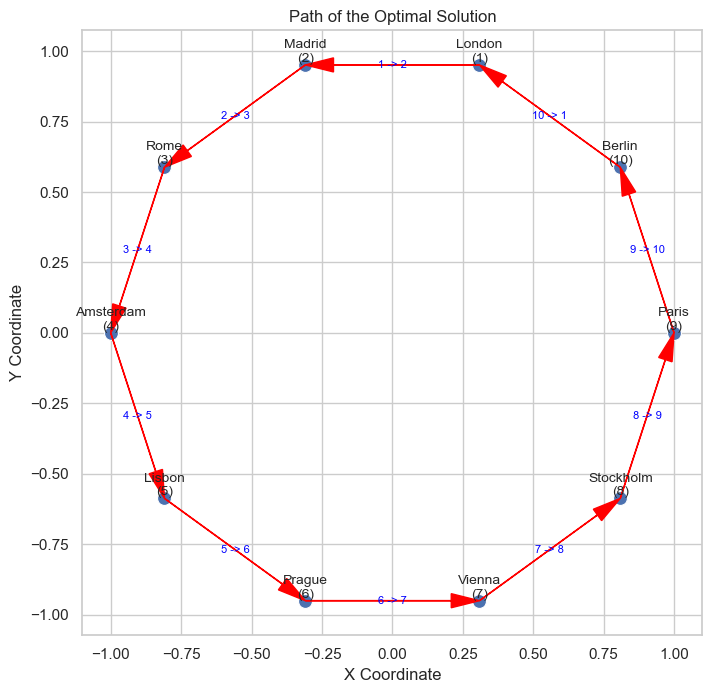

In [136]:
cities = [
    "Paris", "Berlin", "London", "Madrid", "Rome", "Amsterdam", "Lisbon", "Prague", "Vienna", "Stockholm",
]

def genetic_algorithm(cities, max_distance, n_sol, n_cities, n_iterations, cross_rate, mutate_rate, verbose = False, random = False, unit_circle = False):
    if random:
        coords = determine_coords(cities, max_distance)
        cities_selection = initial_cities(n_sol, n_cities, cities)
        solutions_coords = construct_pop_coords(cities_selection, coords)

    elif unit_circle:
        coords_unit_circle = {
    'Paris': (1, 0),
    'Berlin': (np.cos(2*np.pi/10), np.sin(2*np.pi/10)),
    'London': (np.cos(4*np.pi/10), np.sin(4*np.pi/10)),
    'Madrid': (np.cos(6*np.pi/10), np.sin(6*np.pi/10)),
    'Rome': (np.cos(8*np.pi/10), np.sin(8*np.pi/10)),
    'Amsterdam': (np.cos(10*np.pi/10), np.sin(10*np.pi/10)),
    'Lisbon': (np.cos(12*np.pi/10), np.sin(12*np.pi/10)),
    'Prague': (np.cos(14*np.pi/10), np.sin(14*np.pi/10)),
    'Vienna': (np.cos(16*np.pi/10), np.sin(16*np.pi/10)),
    'Stockholm': (np.cos(18*np.pi/10), np.sin(18*np.pi/10))
}
        cities_selection = initial_cities(n_sol, n_cities, cities) # random solutions
        solutions_coords = construct_pop_coords(cities_selection, coords_unit_circle)

    else:
        coord_map_non_random = {
        'Paris': (2.3522, 48.8566),
    'Berlin': (13.4050, 52.5200),
    'London': (-0.1278, 51.5074),
    'Madrid': (-3.7038, 40.4168),
    'Rome': (12.4964, 41.9028),
    'Amsterdam': (4.9041, 52.3676),
    'Lisbon': (-9.1393, 38.7223),
    'Prague': (14.4378, 50.0755),
    'Vienna': (16.3738, 48.2082),
    'Stockholm': (18.0686, 59.3293)
        }
        cities_selection = initial_cities(n_sol, n_cities, cities) # random solutions
        solutions_coords = construct_pop_coords(cities_selection, coord_map_non_random)

    optimal_solution = None
    optimal_dist = 10000
    optimal_score = 0
    
    i = 0
    
    for iteration in range(n_iterations):
        total_distances = calc_total_dist(solutions_coords)
        weights = assign_weights(total_distances)
        selected_solutions = probability_wheel(solutions_coords, weights)

        crossover_results = crossover(selected_solutions, cross_rate)

        mutated_results = mutate(crossover_results, mutate_rate)
        mutated_results = regressed_safeguard(solutions_coords, mutated_results)

        total_distances_after_algo = calc_total_dist(mutated_results)
        weights_new_gen = assign_weights(total_distances_after_algo)

        best_dist = total_distances_after_algo[np.argmax(weights_new_gen)]
        best_sol = mutated_results[np.argmax(weights_new_gen)]
        
        i += 1

        if verbose:
            print(f"best solution : {best_sol} | total dist : {best_dist}")

        if best_dist < optimal_dist:
            optimal_dist = best_dist
            optimal_solution = best_sol

        solutions_coords = mutated_results

    print(f"shortest path found -> {optimal_solution}")
    print(f"distance traveled - > {optimal_dist}")
    
    # this part of the code is for the plot
    city_names = list(optimal_solution.keys())
    coordinates = list(optimal_solution.values())
    x_coords, y_coords = zip(*coordinates)

    sns.set(style='whitegrid')
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x_coords, y=y_coords, s=100)
    plt.title('Path of the Optimal Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # city name and order in solution
    for i, city in enumerate(city_names):
        plt.text(x_coords[i], y_coords[i], f"{city}\n({i+1})", fontsize=10, ha='center', va='bottom')

    # arrows and i -> j in solution
    # this part is chatGPT
    for i in range(len(city_names)):
        start = coordinates[i]
        end = coordinates[(i + 1) % len(city_names)]  # close the loop
        plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                head_width=0.05, head_length=0.1, fc='red', ec='red', length_includes_head=True)
        plt.text((start[0] + end[0]) / 2, (start[1] + end[1]) / 2, f"{i+1} -> {i+2 if i+1<len(city_names) else 1}", fontsize=8,
                ha='center', va='center', color='blue')

    # fix aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

genetic_algorithm(cities = cities, max_distance = 20, n_sol = 100, n_cities = 10, n_iterations = 1000, cross_rate = 0.4, mutate_rate = 0.2, verbose = False, unit_circle = True)